## Task 2: Regional Temperature Changes

### Preprocessing Data

In [3]:
#imports
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [5]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [6]:
df_tas_hist=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")

#  assemble a set of models (source_id) for each experiment + variable combination
models_tas_hist  =set(df_tas_hist.source_id)    # all models that have temperature in the historical simulations
models_tas_ssp585=set(df_tas_ssp585.source_id)  # all models that have temperature in the ssp585     simulations

# let's only keep the models that have all the runs (the intersection of the set)
source_set = set.intersection(models_tas_hist, models_tas_ssp585)
source_list=list(source_set)
print(len(models_tas_hist))
print(len(models_tas_ssp585))
print(len(source_list))

55
35
35


In [7]:
models_no_1850 = ['MPI-ESM1-2-HR', 'AWI-CM-1-1-MR']

In [8]:
source_list.remove('MPI-ESM1-2-HR')
source_list.remove('AWI-CM-1-1-MR')
print(len(source_list))

33


In [10]:
source_list

['KIOST-ESM',
 'CanESM5',
 'EC-Earth3-Veg',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'FGOALS-g3',
 'GFDL-ESM4',
 'MIROC6',
 'CESM2-WACCM',
 'EC-Earth3-CC',
 'MRI-ESM2-0',
 'NorESM2-LM',
 'GFDL-CM4',
 'INM-CM4-8',
 'FGOALS-f3-L',
 'CAS-ESM2-0',
 'TaiESM1',
 'EC-Earth3',
 'IPSL-CM6A-LR',
 'E3SM-1-1',
 'MPI-ESM1-2-LR',
 'NESM3',
 'EC-Earth3-Veg-LR',
 'ACCESS-CM2',
 'IITM-ESM',
 'FIO-ESM-2-0',
 'KACE-1-0-G',
 'INM-CM5-0',
 'NorESM2-MM',
 'ACCESS-ESM1-5',
 'CAMS-CSM1-0',
 'BCC-CSM2-MR',
 'CIESM']

In [11]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

In [12]:
#time index to assign model times to
new_time_index=pd.date_range('1850-01-01', '2099-12-31', freq='ME')
new_time_index

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2099-03-31', '2099-04-30', '2099-05-31', '2099-06-30',
               '2099-07-31', '2099-08-31', '2099-09-30', '2099-10-31',
               '2099-11-30', '2099-12-31'],
              dtype='datetime64[ns]', length=3000, freq='ME')

In [43]:
#regrid to common 1x1 grid
new_lats=np.arange(-87,88)
new_lons=np.arange(1,359)

### 2.1 Analysis for One Model

In [39]:
#query data
df_tas_hist_canesm5=df.query  ("activity_id=='CMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1'")
df_tas_ssp585_canesm5=df.query("activity_id=='ScenarioMIP' & source_id == 'CanESM5' & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1'")
#load data
ds_hist_tas_canesm5 = load_zarr_dset(df_tas_hist_canesm5)
ds_ssp585_tas_canesm5 = load_zarr_dset(df_tas_ssp585_canesm5)
#compute diff between avg over years 2089-2099 and 1989-1999
hist_tas_canesm5 = ds_hist_tas_canesm5.tas.sel(time=slice('1989','1999'))
ssp585_tas_canesm5 = ds_ssp585_tas_canesm5.tas.sel(time=slice('2089','2099'))
#dtas = ssp585_tas_canesm5_w_mean.mean('time') - hist_tas_canesm5_w_mean.mean('time') this doesn't work
dtas = ssp585_tas_canesm5.mean('time')-hist_tas_canesm5.mean('time') #i'm not accessing the weights 
dtas

<xarray.DataArray 'tas' (lat: 64, lon: 128)>
dask.array<sub, shape=(64, 128), dtype=float32, chunksize=(64, 128), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2

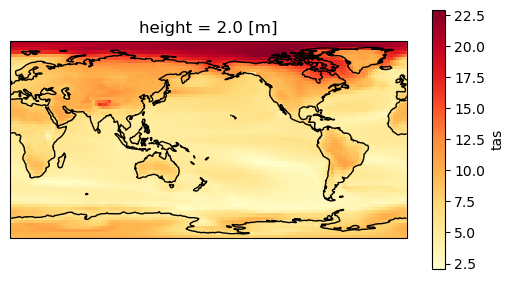

In [38]:
#plot of dtas using cartopy, map of regional warming over the 21st century
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
dtas.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})

### 2.2 Multiple Models

In [15]:
gcm_list = ['KIOST-ESM',
 'CanESM5',
 'EC-Earth3-Veg',
 'CMCC-CM2-SR5',
 'CMCC-ESM2']

In [47]:
#load multiple models
ds_list = list()
for source in gcm_list:
    df_hist_tas=df.query  ("activity_id=='CMIP'         & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='historical'& member_id=='r1i1p1f1' & source_id== @source")
    df_ssp585_tas=df.query("activity_id=='ScenarioMIP'  & table_id == 'Amon' & variable_id == 'tas' & experiment_id=='ssp585'    & member_id=='r1i1p1f1' & source_id== @source")
    ds_hist_tas   =load_zarr_dset(df_hist_tas)
    ds_ssp585_tas =load_zarr_dset(df_ssp585_tas)
    #compute difference between avg over years 2089-2099 and years 1989-1999
    hist_tas = ds_hist_tas.tas.sel(time=slice('1989','1999'))
    ssp585_tas= ds_ssp585_tas.tas.sel(time=slice('2089','2099'))
    dtas = ssp585_tas.mean('time')-hist_tas.mean('time')
    ds_interp = dtas.interp(lat = new_lat, lon = new_lon)
    ds_list.append(ds_interp)
gcm_obs = xr.concat(ds_interp, dim = 'model', coords = 'minimal',compat='override')
gcm_obs

<xarray.DataArray 'tas' (model: 170, lon: 356)>
dask.array<concatenate, shape=(170, 356), dtype=float32, chunksize=(1, 356), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
    lat      int32 -85
  * lon      (lon) int32 2 3 4 5 6 7 8 9 10 ... 350 351 352 353 354 355 356 357
Dimensions without coordinates: model

In [50]:
#problem with this dataset: I don't have tas as a dimension bc it's basically a ds OF tas
#how to fix: i think i need to take the mean of it without accessing the variable and taking it with dim('lon', 'lat', 'time'?)

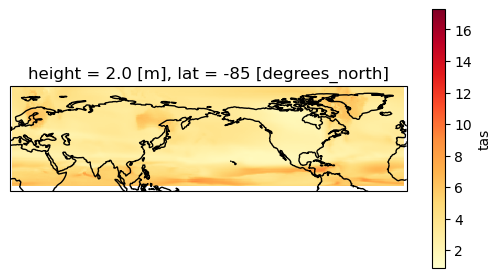

In [48]:
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude = 180))
ax.coastlines()
gcm_obs.plot(ax=ax, cmap = "YlOrRd", transform = ccrs.PlateCarree(), cbar_kwargs = {"shrink": 0.7})